# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 12/10/2024

This notebook will try to perform a point-by-point index of the 2D peaks you segmented.
The point-by-point results (usually saved to a .txt file in the sample PROCESSED_DATA folder) are multi-valued (we can find multiple UBIs at each map voxel).  
You can view the results of the point-by-point process 'live' by running the next notebook (pbp_2_visualise).  
That notebook will also allow you to save a single-valued version of the pbp map to H5, ParaView XDMF and MTEX CTF.
The UBIs we find from the PBP index should have reasonably accurate orientations, but the strains are likely to be poor.  
To get much better strains, slightly better orientations and possibly better grain shapes, you should run pbp_3_refinement
Then run 4_visualise to convert the refinement results to an accurate single-valued map with good strains.

In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [3]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_file = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5'

# which phase to index
phase_str = 'Si'

# filter the columnfile to discard weak peaks
minpkint = 5

# point-by-point parameters
hkl_tol = 0.025
fpks = 0.9
ds_tol = 0.004
etacut = 0.1
ifrac = 5e-3
y0 = 0.0
symmetry = "cubic"
foridx = [0, 1, 3, 5, 7]
forgen = [1, 5, 7]
uniqcut = 0.85
use_cluster = False

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [4]:
# Parameters
PYTHONPATH = "../"
dset_file = "pbp_route/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5"
phase_str = "Si"
minpkint = 0
hkl_tol = 0.025
fpks = 0.9
ds_tol = 0.004
etacut = 0.1
ifrac = 0.005
y0 = 24.24
symmetry = "cubic"
foridx = [0, 1, 3, 5, 7]
forgen = [1, 5, 7]
uniqcut = 0.85
use_cluster = False


In [5]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib ipympl

import ImageD11.sinograms.point_by_point
import ImageD11.sinograms.dataset
import ImageD11.sinograms.properties
import ImageD11.columnfile

import ImageD11.nbGui.nb_utils as utils

In [6]:
# USER: Pass path to dataset file

ds = ImageD11.sinograms.dataset.load(dset_file)
   
sample = ds.sample
dataset = ds.dsname
rawdata_path = ds.dataroot
processed_data_root_dir = ds.analysisroot

print(ds)
print(ds.shape)

dataroot = "/home/esrf/james1997a/Code/ImageD11/test/pbp_route/raw"
analysisroot = "/home/esrf/james1997a/Code/ImageD11/test/pbp_route/processed"
sample = "Si_cube"
dset = "S3DXRD_nt_moves_dty"
shape = ( 41, 3620)
# scans 41 from 1.1 to 41.1
(41, 3620)


In [7]:
# USER: specify the path to the parameter file

par_file = os.path.join(processed_data_root_dir, 'pars.json')

# add them to the dataset

ds.parfile = par_file

ds.save()

In [8]:
# load phases from parameter file

ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Si': <ImageD11.unitcell.unitcell at 0x14a6466af190>}

In [9]:
# now let's select a phase to index from our parameters json

ucell = ds.phases.unitcells[phase_str]

print(ucell.lattice_parameters, ucell.spacegroup)

[ 5.43  5.43  5.43 90.   90.   90.  ] 227


In [10]:
# We will now generate a cf (columnfile) object for the 2D peaks.
# Will be corrected for detector spatial distortion

cf_2d = ds.get_cf_2d()
ds.update_colfile_pars(cf_2d, phase_name=phase_str)

if not os.path.exists(ds.col2dfile):
    # save the 4D peaks to file so we don't have to spatially correct them again
    ImageD11.columnfile.colfile_to_hdf(cf_2d, ds.col2dfile)

In [11]:
# filter the columnfile to discard weak peaks

cf_2d.filter(cf_2d.Number_of_pixels > minpkint)

In [12]:
cosine_tol=np.cos(np.radians(90 - ds.ostep))

pbp_object = ImageD11.sinograms.point_by_point.PBP(ds.parfile,
                                                    ds,
                                                    hkl_tol=hkl_tol,
                                                    fpks=fpks,
                                                    ds_tol=ds_tol,
                                                    etacut=etacut,
                                                    ifrac=ifrac,
                                                    cosine_tol=cosine_tol,
                                                    y0=y0,
                                                    symmetry=symmetry,
                                                    foridx=foridx,
                                                    forgen=forgen,
                                                    uniqcut=uniqcut,
                                                    phase_name=phase_str)

pbp_object.setpeaks(cf_2d)

0 0.3190 (1, 1, 1) 8 79 used, sum_intensity> 13.545
1 0.5209 (2, 0, 2) 12 125 used, sum_intensity> 11.235
2 0.6108 (1, 1, 3) 24 skipped
4 0.7366 (0, 4, 0) 6 skipped
5 0.8027 (3, 1, 3) 24 232 used, sum_intensity> 5.165
6 0.9022 (2, 2, 4) 24 skipped
7 0.9569 (1, 1, 5) 32 276 used, sum_intensity> 9.385
8 1.0418 (4, 4, 0) 12 skipped
9 1.0895 (1, 5, 3) 48 skipped
10 1.1050 (4, 2, 4) 24 skipped
11 1.1647 (6, 2, 0) 24 skipped
12 1.2076 (5, 3, 3) 24 skipped
13 1.2216 (2, 2, 6) 24 skipped
14 1.2759 (4, 4, 4) 8 skipped
15 1.3152 (1, 1, 7) 48 skipped
16 1.3781 (4, 6, 2) 48 skipped
17 1.4146 (3, 1, 7) 72 skipped
18 1.4733 (8, 0, 0) 6 skipped
19 1.5074 (3, 7, 3) 24 skipped
20 1.5186 (4, 6, 4) 24 skipped
21 1.5627 (6, 6, 0) 36 skipped
22 1.5949 (1, 7, 5) 56 skipped
23 1.6055 (2, 6, 6) 24 skipped
24 1.6472 (0, 8, 4) 24 skipped
25 1.6778 (7, 3, 5) 72 skipped
26 1.6879 (8, 2, 4) 48 skipped
27 1.7276 (4, 6, 6) 24 skipped
28 1.7568 (3, 1, 9) 48 skipped
29 1.8044 (8, 4, 4) 24 skipped
30 1.8324 (1, 7, 7) 7

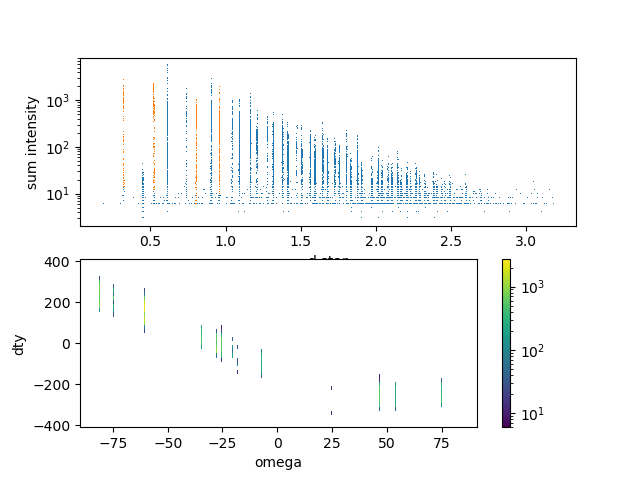

In [13]:
fig, ax = pbp_object.iplot()

In [14]:
if use_cluster:
    bash_script_path = utils.prepare_pbp_bash(pbp_object, PYTHONPATH, minpkint)
    utils.slurm_submit_and_wait(bash_script_path, 15)
else:
    pbp_object.point_by_point(ds.pbpfile, loglevel=3)

{'cosine_tol': 0.0008726643147667022,
 'ds_tol': 0.004,
 'forgen': [1, 5, 7],
 'hkl_tol': 0.025,
 'hmax': 5,
 'minpks': 68,
 'uniqcut': 0.85,
 'y0': 24.24,
 'ymin': -400.0000639988327,
 'ystep': 20.000003199941638}


26.195844411849976 seconds 0.012936219462641963 s per point
26.19144606590271 seconds 0.012934047439951956 s per point without setup


In [15]:
ds.save()

In [16]:
# Now that we're happy with our indexing parameters, we can run the below cell to do this in bulk for many samples/datasets
# by default this will do all samples in sample_list, all datasets with a prefix of dset_prefix
# you can add samples and datasets to skip in skips_dict

skips_dict = {
    "FeAu_0p5_tR_nscope": ["top_-50um", "top_-100um"]
}

dset_prefix = "top"

sample_list = ["FeAu_0p5_tR_nscope"]
    
samples_dict = utils.find_datasets_to_process(ds.dataroot, skips_dict, dset_prefix, sample_list)
    
# manual override:
# samples_dict = {"FeAu_0p5_tR_nscope": ["top_100um", "top_150um"]}
    
# now we have our samples_dict, we can process our data:

sbats = []
for sample, datasets in samples_dict.items():
    for dataset in datasets:
        print(f"Processing dataset {dataset} in sample {sample}")
        dset_path = os.path.join(ds.analysisroot, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")
        if not os.path.exists(dset_path):
            print(f"Missing DataSet file for {dataset} in sample {sample}, skipping")
            continue
        
        print("Importing DataSet object")
        
        ds = ImageD11.sinograms.dataset.load(dset_path)
        print(f"I have a DataSet {ds.dset} in sample {ds.sample}")
        if os.path.exists(ds.pbpfile):
            print(f"Already have PBP file for {dataset} in sample {sample}, skipping")
            continue
        
        ds.parfile = par_file
        ds.save()
        
        ds.phases = ds.get_phases_from_disk()
        
        cf_2d = ds.get_cf_2d()
        ds.update_colfile_pars(cf_2d, phase_name=phase_str)

        if not os.path.exists(ds.col2dfile):
            ImageD11.columnfile.colfile_to_hdf(cf_2d, ds.col2dfile)
            
        cf_2d.filter(cf_2d.Number_of_pixels > minpkint)
        
        pbp_object = ImageD11.sinograms.point_by_point.PBP(ds.parfile,
                                                            ds,
                                                            hkl_tol=hkl_tol,
                                                            fpks=fpks,
                                                            ds_tol=ds_tol,
                                                            etacut=etacut,
                                                            ifrac=ifrac,
                                                            cosine_tol=cosine_tol,
                                                            y0=y0,
                                                            symmetry=symmetry,
                                                            foridx=foridx,
                                                            forgen=forgen,
                                                            uniqcut=uniqcut,
                                                            phase_name=phase_str)
        
        pbp_object.setpeaks(cf_2d)

        if use_cluster:
            # get the sbat and submit them all at once
            bash_script_path = utils.prepare_pbp_bash(pbp_object, PYTHONPATH, minpkint)
            sbats.append(bash_script_path)
            # utils.slurm_submit_and_wait(bash_script_path, 15)
        else:
            # do it locally
            pbp_object.point_by_point(ds.pbpfile, loglevel=3)
        
        ds.save()
    if use_cluster:
        utils.slurm_submit_many_and_wait(sbats, wait_time_sec=60)

print("Done!")

Done!
